# LDA Model

LDA is shorted for Latent Dirchlet allocation model. It is a topic model commonly used for document .

In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os

import codecs
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence

from IPython.display import display


%matplotlib notebook
# %matplotlib inline

In [2]:
train = pd.read_csv('./data/training_variants')
test = pd.read_csv('./data/test_variants')
trainx = pd.read_csv('./data/training_text', sep="\|\|", engine='python', header=None, skiprows=1,
                     names=["ID", "Text"])
testx = pd.read_csv('./data/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID", "Text"])

train = pd.merge(train, trainx, how='left', on='ID')
y = train['Class'].values
# train = train.drop('Class', axis=1)

test = pd.merge(test, testx, how='left', on='ID')
pid = test['ID'].values

In [8]:
sample_text = train['Text'][1]

nlp = spacy.load('en')

parsed_text = nlp(train['Variation'][0])
for pt in parsed_text:
    print(pt.lemma_)

truncate
mutation


In [5]:
def line_review(filename):
    for index, row in filename.iterrows():
        yield row['Text']

def lemmatized_text (filename):
    
    for parsed_text in nlp.pipe(line_review(filename),
                               batch_size = 10,
                               n_threads=4):
        
        prof_token = [token.lemma_ for token in parsed_text 
                      if token.is_oov 
                      and not token.is_space
                      and not token.like_num
                      and not token.is_digit
                      and not token.suffix_.endswith('%')
                      and (token.is_ascii | any(u"\u03B1" <= c <= u"\u03C9" for c in token.text))
                      and not token.is_bracket
                      and not token.like_url and token.__len__()< 15]
        

        yield u' '.join(prof_token)

def extract_gene_position(filename):
    
    row_iter = filename.iterrows()
    for parsed_text in nlp.pipe(line_review(filename),
                               batch_size = 10,
                               n_threads=4):
        row = next(row_iter)[1]
        
        gene = nlp(row['Gene'])
        
        if gene.__len__() ==1:
            gene_index = [token.i for token in parsed_text 
                      if token.orth_ == gene[0].orth_ ]
        else:
            gene_index = [token.i for token in parsed_text 
                      if (token.lemma_ == gene[0].lemma_ & token.lemma_ == gene[1].lemma_) ]
        
        yield gene_index
        

def extract_variation_position(filename):
    
    row_iter = filename.iterrows()
    for parsed_text in nlp.pipe(line_review(filename),
                               batch_size = 10,
                               n_threads=4):
        row = next(row_iter)[1]
        
        variation = nlp(row['Variation'])
        if variation.__len__() ==1:
            variation_index = [token.i for token in parsed_text 
                      if token.lemma_ == variation[0].lemma_ ]
        else:
            variation_index = [token.i for token in parsed_text 
                      if (token.lemma_ == variation[1].lemma_ or token.lemma_ == variation[0].lemma_) ]
        
        yield variation_index
        

def extract_text_length(filename):
    for parsed_text in nlp.pipe(line_review(filename),
                               batch_size = 10,
                               n_threads=4):
        yield parsed_text.__len__()

In [6]:
def extract_position_plain(row):
    
    col_names = row.index.tolist()
    
    col_name = col_names[0]
    genevariation = nlp(row[col_name])
    parsed_text = nlp(row['Text'])
    genevariation_index = []
    
    if genevariation.__len__() ==1:
        genevariation_index = [token.i for token in parsed_text
                      if token.lemma_ == genevariation[0].lemma_ ]
    
    else:
        genevariation_index = [token.i for token in parsed_text 
                      if (token.lemma_ == genevariation[0].lemma_ or token.lemma_ == genevariation[1].lemma_)]
    return genevariation_index


def text_prof_extraction_plain(row):
    parsed_text = nlp(row['Text'])
        
    prof_token = [token.lemma_ for token in parsed_text 
                      if token.is_oov 
                      and not token.is_space
                      and not token.like_num
                      and not token.is_digit
                      and not token.suffix_.endswith('%')
                      and (token.is_ascii | any(u"\u03B1" <= c <= u"\u03C9" for c in token.text))
                      and not token.is_bracket
                      and not token.like_url and token.__len__()< 15]
    
    return ' '.join(prof_token)

def text_length_plain(row):
    return nlp(row['Text']).__len__()

In [7]:
data_dir = './data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_clean_text_path = os.path.join(data_dir, 'train_clean_text.csv') 

if not os.path.isfile(train_clean_text_path):
    train_clean_text = train.copy()
    train_clean_text['text_prof_tokens'] = train_clean_text.apply(text_prof_extraction_plain, axis=1)
    train_clean_text.to_csv(train_clean_text_path)
else:
    train_clean_text = pd.read_csv(train_clean_text_path)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [78]:
train_text = train['Text'].dropna().copy()

In [79]:
tf_vectroizer =  CountVectorizer(max_df= 0.8, min_df = 1, 
                                max_features=600,
                               stop_words = 'english')

tf = tf_vectroizer.fit_transform(train_text)

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=1,
                                   max_features=200,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(train_text)

In [80]:
lda = LatentDirichletAllocation(n_components=20, max_iter=20,
                                learning_method='online',
                                learning_offset=10,
                                random_state=0)

lda_tf = lda.fit(tf)
lda_tf_topics = lda.fit_transform(tf)

array([[  4.15282401e-05,   1.35056630e-01,   4.15282400e-05, ...,
          1.32582047e-01,   4.15282402e-05,   2.50165141e-01],
       [  4.38596497e-05,   3.47651903e-02,   4.05538767e-02, ...,
          4.38596501e-05,   4.38596500e-05,   4.38596501e-05],
       [  4.38596497e-05,   3.47651903e-02,   4.05538767e-02, ...,
          4.38596501e-05,   4.38596500e-05,   4.38596501e-05],
       ..., 
       [  4.81958080e-03,   2.91020587e-01,   6.50195087e-05, ...,
          6.50195076e-05,   6.50195074e-05,   6.50195069e-05],
       [  5.38213146e-05,   3.43933046e-01,   5.38213145e-05, ...,
          5.38213140e-05,   8.35047445e-02,   5.38213142e-05],
       [  2.77469484e-05,   2.90665350e-01,   3.93294167e-03, ...,
          2.77469484e-05,   1.02514501e-01,   2.77469484e-05]])

In [13]:
n_top_words = 5

topic_summaries = []
topic_word = lda.components_  # all topic words
vocab = tf_vectroizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # append!


In [14]:
from sklearn.manifold import TSNE

threshold = 0.5
_idx = np.amax(lda_tf_topics, axis=1) > threshold  # idx of doc that above the threshold
lda_tf_topics = lda_tf_topics[_idx]

_lda_keys = []
for i in range(lda_tf_topics.shape[0]):
    _lda_keys +=  lda_tf_topics[i].argmax(),

tsne_model = TSNE(n_components=2, 
                  perplexity=30.0,
                  verbose=1, 
                  random_state=0, 
                  angle=0.99, 
                  init='pca')
tsne_lda = tsne_model.fit_transform(lda_tf_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1767 samples in 0.001s...
[t-SNE] Computed neighbors for 1767 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1767
[t-SNE] Computed conditional probabilities for sample 1767 / 1767
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.147724
[t-SNE] Error after 1000 iterations: 0.110913


<IPython.core.display.Javascript object>


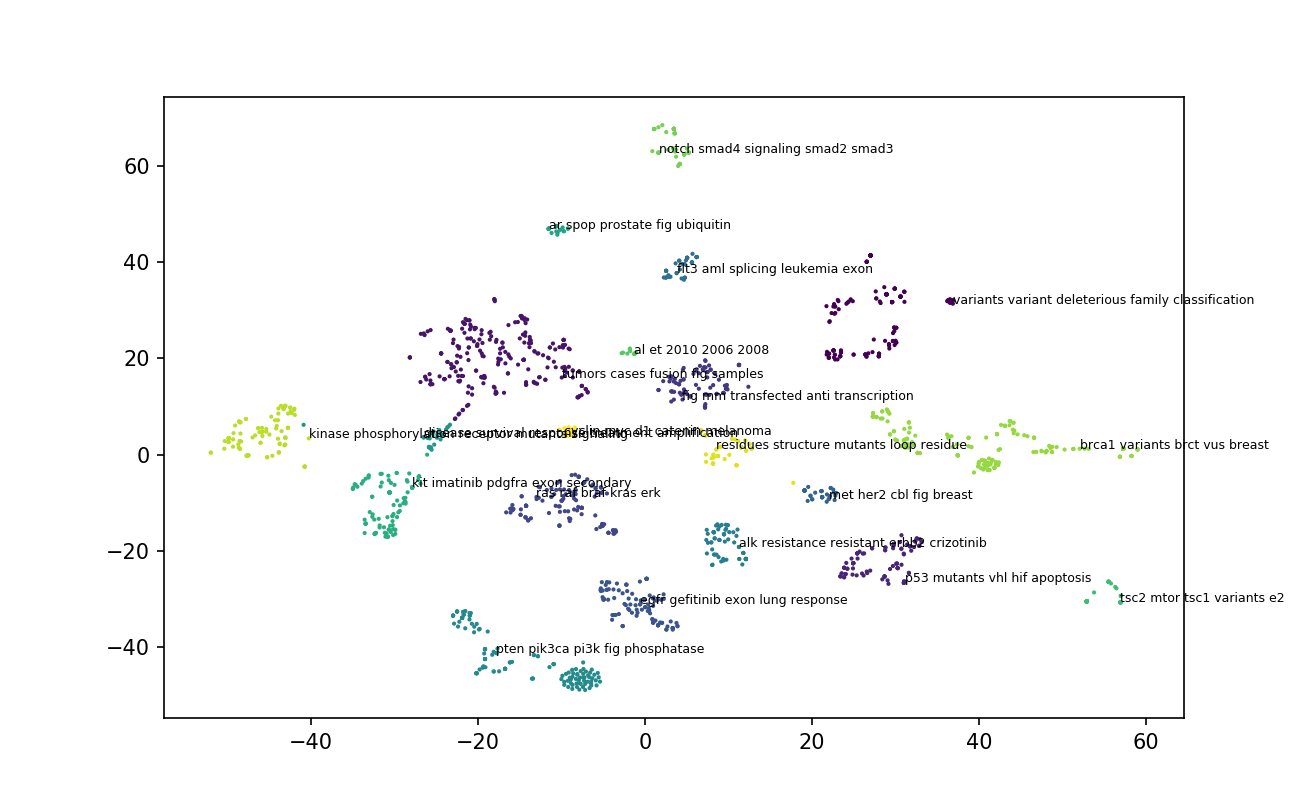

In [32]:
plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c = _lda_keys, s=1)

topic_coord = np.empty((lda_tf_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]
for i in range(lda_tf_topics.shape[1]):
    plt.text(topic_coord[i, 0], topic_coord[i, 1],  topic_summaries[i], fontsize=6)

plt.show()

In [108]:
train_text_clean = train_clean_text['text_prof_tokens'].dropna().copy()
tf_vectroizer_clean =  CountVectorizer(max_df= 0.8, min_df = 1, 
                                max_features=2000,
                               stop_words = 'english')
tf_clean = tf_vectroizer_clean.fit_transform(train_text_clean)

In [109]:
lda_clean = LatentDirichletAllocation(n_components=10, max_iter=20,
                                learning_method='online',
                                learning_offset=10,
                                random_state=0)

lda_tf_clean = lda_clean.fit(tf_clean)
lda_tf_topics_clean = lda_clean.fit_transform(tf_clean)

In [58]:
n_top_words = 5

topic_summaries_clean = []
topic_word_clean = lda_clean.components_  # all topic words
vocab = tf_vectroizer_clean.get_feature_names()
for i, topic_dist in enumerate(topic_word_clean):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries_clean.append(' '.join(topic_words)) # append!

In [59]:
from sklearn.manifold import TSNE

threshold = 0.2
_idx = np.amax(lda_tf_topics_clean, axis=1) > threshold  # idx of doc that above the threshold
lda_tf_topics_clean = lda_tf_topics_clean[_idx]

_lda_keys = []
for i in range(lda_tf_topics_clean.shape[0]):
    _lda_keys +=  lda_tf_topics_clean[i].argmax(),

tsne_model_clean = TSNE(n_components=2, 
                  perplexity=30.0,
                  verbose=1, 
                  random_state=0, 
                  angle=0.99, 
                  init='pca')
tsne_lda_clean = tsne_model_clean.fit_transform(lda_tf_topics_clean)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3313 samples in 0.002s...
[t-SNE] Computed neighbors for 3313 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3313
[t-SNE] Computed conditional probabilities for sample 2000 / 3313
[t-SNE] Computed conditional probabilities for sample 3000 / 3313
[t-SNE] Computed conditional probabilities for sample 3313 / 3313
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.485470
[t-SNE] Error after 1000 iterations: 0.384835


<IPython.core.display.Javascript object>


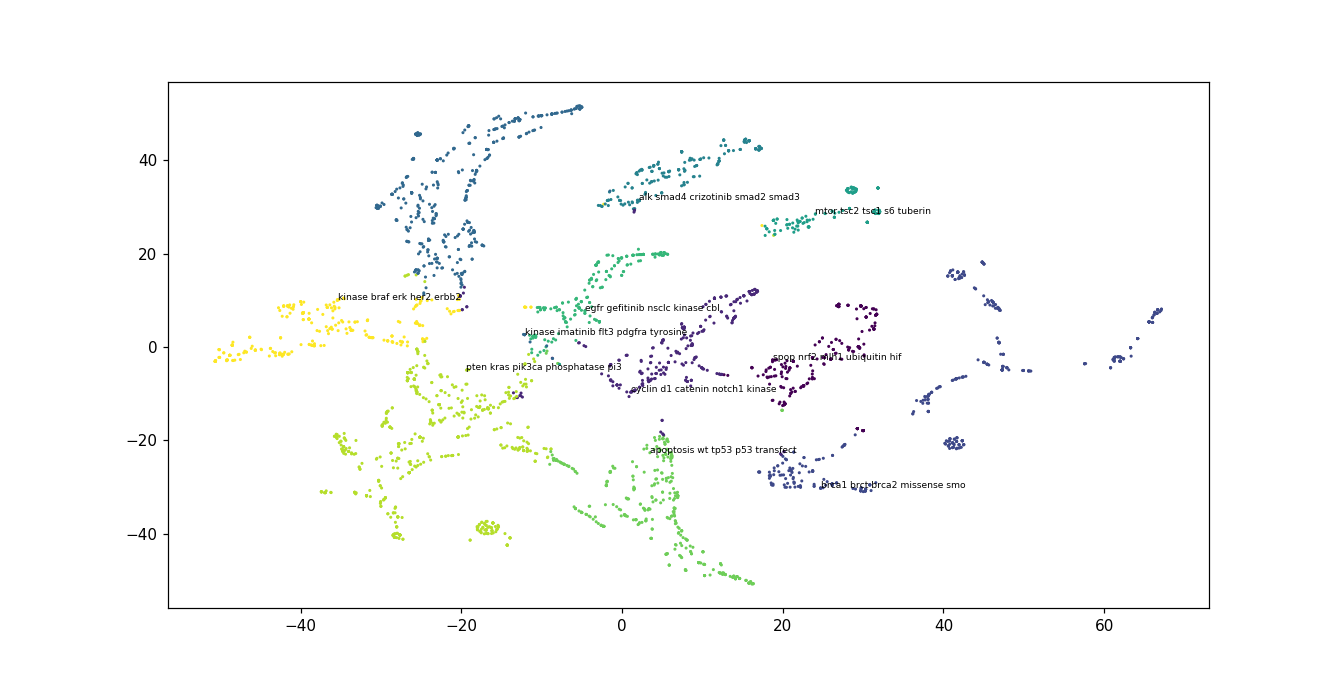

In [60]:
plt.scatter(tsne_lda_clean[:, 0], tsne_lda_clean[:, 1], c = _lda_keys, s=1)

topic_coord_clean = np.empty((lda_tf_topics_clean.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord_clean).any():
        break
    topic_coord_clean[topic_num] = tsne_lda_clean[_lda_keys.index(topic_num)]
    
for i in range(lda_tf_topics_clean.shape[1]):
    plt.text(topic_coord_clean[i, 0], topic_coord_clean[i, 1],  topic_summaries_clean[i], fontsize=6)
plt.show()

# Classification using LDA results

## what is LDA results means?

In [88]:
lda_tf_topics_clean.shape

(3313, 10)

(3316,)
[1 6 6 ..., 8 8 8]
[  0 566 452  89 686 242 273 952  19  37]
[261 298 478 474 204 139 204 380 589 289]


<IPython.core.display.Javascript object>


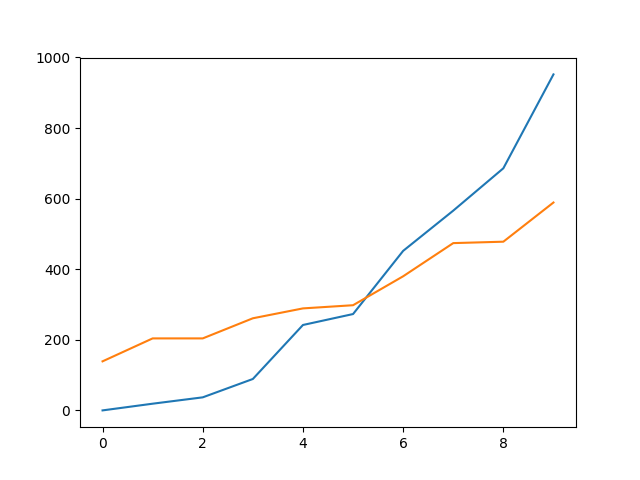

In [165]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_predict
df_null = train_clean_text['text_prof_tokens'].isnull()
df_null
# lr = LinearRegression()
tc = train['Class'][~df_null]
# lda_tf_topics_clean.shape
print(tc.shape)
print(np.argmax(lda_tf_topics_clean, axis=1).reshape(-1))
lrreg =lr.fit(np.argmax(lda_tf_topics_clean, axis=1).reshape([3316, 1]), tc)
lrreg.coef_
# lrreg.predict(np.argmax(lda_tf_topics_clean, axis=1)).reshape([3316, 1])
# predicted = lrreg.predicted(lda_tf_topics_clean)
# predicted = cross_val_predict(lr, lda_tf_topics_clean.T, tc, cv=10)
# plt.scatter(tc, predicted, edgecolors=(0, 0, 0))
# plt.show()
# tf_clean.shape



print(np.bincount(tc))
print(np.bincount(np.argmax(lda_tf_topics_clean, axis=1)))
plt.plot(np.sort(np.bincount(tc)))
plt.plot(np.sort(np.bincount(np.argmax(lda_tf_topics_clean, axis=1))))
plt.show()

In [63]:
# variation_in_cluster = pd.DataFrame()
# for token in topic_summaries_clean[9].split(' '):
#     variation_in_cluster = variation_in_cluster.append(pd.DataFrame(train[train.apply(lambda x: x['Variation'].lower()==token, axis=1)]))
# variation_in_cluster

confusion matrix, cross entropy loss(log-loss), and Area under curve (AUC) are some of the most popular metrics